## Imports

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
import cv2
from skimage.feature import local_binary_pattern
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from skimage.feature import hog
from sklearn.model_selection import cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA

## Functions

In [33]:
def extract_lbp_features(image):
    num_points = 8
    radius = 1
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Extrahiere die LBP-Merkmale aus dem Graustufenbild
    lbp = local_binary_pattern(gray_image, num_points, radius, method='ror')
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, num_points + 3), range=(0, num_points + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)
    return hist

#def extract_hog_features(image):
 #   gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
 #   hog_features = hog(gray_image, orientations=9, pixels_per_cell=(16, 16), cells_per_block=(2, 2), visualize=False)
 #   return hog_features

def extract_hog_features(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Create a HOG detector with customized parameters
    winSize = (64, 64)
    blockSize = (32, 32)  
    blockStride = (16, 16)
    cellSize = (16, 16)
    nbins = 9
    hog = cv2.HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins)
    # Extract the HOG features
    hog_features = hog.compute(gray_image)
    return hog_features

def extract_fisherface_features(image):
    # Convert the image from RGB to Grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Load the Fisherface recognizer
    fisherface_recognizer = cv2.FisherFaceRecognizer_create()
    # Extract Fisherface features
    fisherface_feature = fisherface_recognizer.compute(gray_image)
    return fisherface_feature

def predict_image_HOG(image, classifier, hog_pca_transformer):
    predict_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Verkleinere das Bild
    predict_resized_image = cv2.resize(predict_image, (255, 255))
    # Extrahiere die HOG-Merkmale
    hog_features = extract_hog_features(predict_resized_image)
    hog_features_pca = hog_pca_transformer.transform(hog_features.reshape(1, -1))
  # Führe die Vorhersage mit dem Klassifikator durch
    probabilities = classifier.predict_proba(hog_features_pca)[0]
    predicted_class_index = np.argmax(probabilities)
    predicted_class_name = classifier.classes_[predicted_class_index]
    confidence = probabilities[predicted_class_index]
    return predicted_class_name, confidence

def predict_image_LBP(image, classifier):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Verkleinere das Bild
    resized_image = cv2.resize(image, (255, 255))
    # Extrahiere die LBP-Merkmale
    lbp_features = extract_lbp_features(resized_image)
    # Führe die Vorhersage mit dem Klassifikator durch
    prediction = classifier.predict([lbp_features])[0]
    # Bestimme die Vertrauenswahrscheinlichkeit für die Vorhersage
    confidence = max(classifier.predict_proba([lbp_features])[0])
    return prediction, confidence

def predict_image_Fisherface(image, classifier):
    # Convert the image from BGR to RGB
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Resize the image to a desired size
    resized_image = cv2.resize(rgb_image, (255, 255))
    # Extract Fisherface features
    fisherface_feature = extract_fisherface_features(resized_image)
    # Perform prediction using the classifier
    prediction = classifier.predict([fisherface_feature])[0]
    # Determine the confidence level for the prediction
    confidence = max(classifier.predict_proba([fisherface_feature])[0])
    return prediction, confidence
    
def detect_face(image_path):
    # Laden des Gesichtserkennungs-Klassifikators (Haar-Cascade)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    # Laden des Bildes
    image = cv2.imread(image_path)
    if image is not None:
        # Konvertieren des Bildes in Graustufen
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # Gesichter im Bild erkennen
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(200, 200))
        if len(faces) > 0:
            # Nehme das erste erkannte Gesicht
            (x, y, w, h) = faces[0]
            # Schneide das Gesicht aus
            face = image[y:y+h, x:x+w]
             # Zeichne ein Rechteck um das erkannte Gesicht
            ##cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 2)
            return face
        else:
            print(f"No face detected in {image_path}")
            return None
    else:
        print(f"Failed to load image: {image_path}")
        return None

# Laden der Bilder und Extrahieren der Merkmale
def load_images_and_extract_features(data_folder, feature_extractor):
    features = []
    labels = []
    for folder_name in os.listdir(data_folder):
        folder_path = os.path.join(data_folder, folder_name)
        if os.path.isdir(folder_path):
            for file_name in os.listdir(folder_path):
                image_path = os.path.join(folder_path, file_name)
                face = detect_face(image_path)
                if face is not None:
                    # Convert the image from BGR to RGB
                    rgb_face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
                    resized_face = cv2.resize(rgb_face, (255, 255))
                    feature = feature_extractor(resized_face)
                    features.append(feature)
                    labels.append(folder_name)
                else:
                    print(f"Failed to detect face in image: {image_path}")
    return np.array(features), np.array(labels)

def apply_pca(features, variance_threshold):
    pca = PCA(n_components = variance_threshold, svd_solver='full')
    pca.fit(features)
    features_reduced = pca.transform(features)
    return features_reduced, pca

# Funktion zur Berechnung des Durchschnitts der Merkmale für jede Klasse
def calculate_average_features_by_class(features, labels):
    features_by_class = {}
    class_counts = {}

    # Iteration über Merkmale und Labels
    for feature, label in zip(features, labels):
        if label not in features_by_class:
            features_by_class[label] = [feature]
            class_counts[label] = 1
        else:
            features_by_class[label].append(feature)
            class_counts[label] += 1

    # Berechnung des Durchschnitts der Merkmale für jede Klasse
    average_features = []
    class_labels = []

    for label, features_list in features_by_class.items():
        average_feature = np.mean(features_list, axis=0)
        average_features.append(average_feature)
        class_labels.append(label)

    return np.array(average_features), np.array(class_labels), class_counts





## Face detection auf zu trainierenden Bildern

In [ ]:
#Pfad zum Ordner mit den Unterordnern für jede Person
base_path = "Bilder"

# Zielordner für die geschnittenen Gesichter
output_folder = 'Bilder_detected_faces'

# Erstellen des Zielordners, falls er noch nicht existiert
output_path = output_folder
os.makedirs(output_path, exist_ok=True)

# Durchlaufen der Ordner im Basispfad
for person_folder in os.listdir(base_path):
    person_folder_path = os.path.join(base_path, person_folder)
    # Überprüfen, ob es sich um einen Ordner handelt
    if os.path.isdir(person_folder_path):
        # Durchlaufen der Bilder im Unterordner
        for filename in os.listdir(person_folder_path):
            image_path = os.path.join(person_folder_path, filename)
            # Gesichtserkennung durchführen
            face = detect_face(image_path)
            if face is not None:
                # Pfad für das ausgeschnittene Gesicht
                new_folder_path = os.path.join(output_path, person_folder)
                os.makedirs(new_folder_path, exist_ok=True)
                new_image_path = os.path.join(new_folder_path, f"{filename.split('.')[0]}_face.jpg")
                # Speichern des ausgeschnittenen Gesichts als neues Bild
                cv2.imwrite(new_image_path, face)
                print(f"Gesicht in {filename} wurde erfolgreich ausgeschnitten und als {new_image_path} gespeichert.")
            else:
                print(f"Fehler beim Ausschneiden des Gesichts in {filename}.")

print("Gesichtserkennung und Ausschneiden abgeschlossen.")

## Erstelle Augmented Bilder

In [16]:
# Define the path to the dataset folder
data_folder = "Bilder_detected_faces"

# Liste zum Speichern der Bilder und ihrer Labels
augmented_images = []
augmented_labels = []

# Iterate over the folders in the dataset folder
for folder_name in os.listdir(data_folder):
    folder_path = os.path.join(data_folder, folder_name)
    # Check if the item is a folder
    if os.path.isdir(folder_path):
        # Iterate over the files in the folder
        for file_name in os.listdir(folder_path):
            # Assuming the files are image files, you can adjust the file type according to your dataset
            # Read the image using OpenCV
            if file_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_path = os.path.join(folder_path, file_name)
                image = cv2.imread(image_path)
                # Check if the image is loaded successfully
                if image is not None:
                    # Convert the image from BGR to RGB
                    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    # Resize the image to a desired size
                    resized_image = cv2.resize(rgb_image, (255, 255))
                    # Perform image augmentation using Keras ImageDataGenerator
                    datagen = ImageDataGenerator(
                        rotation_range=20,
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        shear_range=0.2,
                        zoom_range=0.2,
                        horizontal_flip=True,
                        fill_mode='constant'
                    )
                    # Reshape the image to add batch dimension
                    reshaped_image = resized_image.reshape((1,) + resized_image.shape)
                    # Generate augmented images and append to the list
                    i = 0
                    for batch in datagen.flow(reshaped_image, batch_size=1):
                        augmented_image = batch[0].astype(np.uint8)
                        augmented_images.append(augmented_image)
                        augmented_labels.append(folder_name)  # Hinzufügen des Labels (Ordnername)
                        i += 1
                        if i >= 200:
                            break  # Break the loop after generating 100 augmented images
                else:
                    print(f"Failed to load image: {image_path}")
            else:
                print(f"Skipping non-image file: {file_name}")

# Ausgabe der Anzahl der geladenen Bilder
print(f"Total images: {len(augmented_images)}")
print(f"Total labels: {len(augmented_labels)}")

Total images: 5600
Total labels: 5600


## Hog Training Feature Extraction

In [17]:
# Initialize empty lists to store HOG features and labels
hog_features = []
hog_labels = []

# Iterate over the images and labels in the lists
for image, label in zip(augmented_images, augmented_labels):
    hog_feature = extract_hog_features(image)
    # Add the HOG feature to the list of features
    hog_features.append(np.array(hog_feature))
    # Add the label to the list of labels
    hog_labels.append(label)
    # Print HOG features and label
    print(f"HOG features: {hog_feature}, Label: {label}")

hog_features_array = np.array(hog_features)
hog_features_reshaped = hog_features_array.reshape(len(hog_features), -1)
hog_features, hog_pca_transformer = apply_pca(hog_features_reshaped, 0.95)
print(f"Total HOG features: {len(hog_features)}")
print(f"Total labels: {len(hog_labels)}")

HOG features: [0.         0.         0.         ... 0.06859279 0.10522696 0.16152544], Label: Nino
HOG features: [0.24637191 0.24637191 0.1742149  ... 0.         0.         0.        ], Label: Nino
HOG features: [0.28421065 0.05996654 0.20093606 ... 0.         0.         0.        ], Label: Nino
HOG features: [0.15412404 0.08857375 0.19066744 ... 0.03931691 0.01943532 0.01495016], Label: Nino
HOG features: [0.         0.         0.         ... 0.08847449 0.10740574 0.16872315], Label: Nino
HOG features: [0.         0.         0.         ... 0.2521517  0.2521517  0.15538168], Label: Nino
HOG features: [0.         0.         0.         ... 0.057909   0.08823969 0.16146374], Label: Nino
HOG features: [0.         0.         0.         ... 0.07965211 0.12013451 0.2610955 ], Label: Nino
HOG features: [0.00668482 0.0487669  0.12074371 ... 0.09185446 0.12421729 0.23888007], Label: Nino
HOG features: [0.2859045  0.2859045  0.28173134 ... 0.         0.         0.        ], Label: Nino
HOG featur

## LBP Training Feature Extraction

In [ ]:
# Initialize empty lists to store LBP features
lbp_features = []
lbp_labels = []

# Parameter für LBP festlegen
num_points = 24
radius = 2

# Iterate over the images and labels in the lists
for image, label in zip(augmented_images, augmented_labels):
    # Extract LBP features
    lbp_feature = extract_lbp_features(image)
    # Flatten the LBP feature array and append to the list of features
    lbp_features.append(lbp_feature)
    # Add the label to the list of labels
    lbp_labels.append(label)
    # Print LBP features and label

    print(f"LBP features: {lbp_feature}, Label: {label}")


#lbp_features_array = np.array(lbp_features)
#lbp_features_reshaped = lbp_features_array.reshape(len(lbp_features), -1)
#anzahl_samples = lbp_features_reshaped.shape[0]
#print("Anzahl der Samples:", anzahl_samples)
print(f"Total LBP features: {len(lbp_features)}")
print(f"Total labels: {len(lbp_labels)}")

## Fisherface Training Feature Extraction

In [ ]:
## Fisherface Training Feature Extraction
# Initialize empty lists to store Fisherface features
fisherface_features = []
fisherface_labels = []

# Iterate over the images and labels in the lists
for image, label in zip(augmented_images, augmented_labels):
    # Extract Fisherface features
    fisherface_feature = extract_fisherface_features(image)
    # Append the Fisherface feature to the list of features
    fisherface_features.append(fisherface_feature)
    # Add the label to the list of labels
    fisherface_labels.append(label)
    # Print Fisherface features and label
    print(f"Fisherface features: {fisherface_feature}, Label: {label}")

print(f"Total Fisherface features: {len(fisherface_features)}")
print(f"Total labels: {len(fisherface_labels)}")

## Random Forest LBP

In [18]:
## lbp Random Forest
# Laden der Trainingsdaten für LBP
X_train_lbp = lbp_features
y_train_lbp = lbp_labels

# Laden der Testdaten für LBP
X_test_lbp, y_test_lbp = load_images_and_extract_features("Test", lambda img: extract_lbp_features(img))

# Initialisierung des Random-Forest-Klassifikators
rf_classifier_lbp = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, verbose=0 , max_features='sqrt', criterion='gini')
 
# Durchführung der Kreuzvalidierung mit 5 Faltungen
cv_scores_lbp = cross_val_score(rf_classifier_lbp, X_train_lbp, y_train_lbp, cv=5)

# Trainieren des Random-Forest-Modells auf dem gesamten Trainingsdatensatz
rf_classifier_lbp.fit(X_train_lbp, y_train_lbp)
 
# Evaluierung des Modells auf den Testdaten für LBP
accuracy_lbp = rf_classifier_lbp.score(X_test_lbp, y_test_lbp)
predicted_lbp = rf_classifier_lbp.predict(X_test_lbp)

# Ausgabe der Ergebnisse
print("Cross-Validation Scores lbp:", cv_scores_lbp)
print("Mean Accuracy (Cross-Validation) lbp:", cv_scores_lbp.mean())
print("Accuracy (Test Set) lbp:", accuracy_lbp)
print("Predicted (Test Set) lbp:", predicted_lbp)

NameError: name 'lbp_features' is not defined

## Random Forest hog

In [19]:
## HOG Randon Forest
X_train_hog = hog_features
y_train_hog = hog_labels

# Laden der Testdaten für HOG
X_test_hog, y_test_hog = load_images_and_extract_features("Test", lambda img: extract_hog_features(img))

print(f"Total HOG features: {len(X_train_hog)}")
# Initialisierung des Random-Forest-Klassifikators
rf_classifier_hog = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1, verbose=0, max_features='sqrt', criterion='gini')

# Durchführung der Kreuzvalidierung mit 5 Faltungen
cv_scores = cross_val_score(rf_classifier_hog, X_train_hog, y_train_hog, cv=5)

# Trainieren des Random-Forest-Modells auf dem gesamten Trainingsdatensatz
rf_classifier_hog.fit(X_train_hog, y_train_hog)

# Iteration über jedes Bild im Testdatensatz und Klassifizierung
correct_predictions = 0
for i, image in enumerate(X_test_hog):
    # Anwenden des PCA-Transformers auf das Bild
    image_pca = hog_pca_transformer.transform(image.reshape(1, -1))
    # Durchführen der Vorhersage mit dem trainierten Modell
    prediction = rf_classifier_hog.predict(image_pca)
    # Ausgabe der Vorhersage für jedes Bild
    print(f"Prediction for image {i+1}: {prediction}")
    if prediction == y_test_hog[i]:
        correct_predictions += 1
    # Berechnung der Genauigkeit
    accuracy = correct_predictions / len(y_test_hog)


# Ausgabe der Ergebnisse
print("Cross-Validation Scores hog:", cv_scores)
print("Mean Accuracy (Cross-Validation) hog:", cv_scores.mean())
print(f"Accuracy: {accuracy}")


Total HOG features: 5600


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 116 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   22.7s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 276 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 116 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   20.8s finished
[

building tree 1 of 300building tree 2 of 300

building tree 3 of 300
building tree 4 of 300
building tree 5 of 300
building tree 6 of 300
building tree 7 of 300
building tree 8 of 300
building tree 9 of 300
building tree 10 of 300
building tree 11 of 300
building tree 12 of 300
building tree 13 of 300
building tree 14 of 300
building tree 15 of 300
building tree 16 of 300
building tree 17 of 300
building tree 18 of 300
building tree 19 of 300
building tree 20 of 300
building tree 21 of 300
building tree 22 of 300
building tree 23 of 300
building tree 24 of 300
building tree 25 of 300
building tree 26 of 300
building tree 27 of 300
building tree 28 of 300


[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    2.0s


building tree 29 of 300
building tree 30 of 300
building tree 31 of 300
building tree 32 of 300
building tree 33 of 300
building tree 34 of 300
building tree 35 of 300
building tree 36 of 300
building tree 37 of 300
building tree 38 of 300
building tree 39 of 300
building tree 40 of 300
building tree 41 of 300
building tree 42 of 300
building tree 43 of 300
building tree 44 of 300
building tree 45 of 300
building tree 46 of 300
building tree 47 of 300
building tree 48 of 300
building tree 49 of 300
building tree 50 of 300
building tree 51 of 300
building tree 52 of 300
building tree 53 of 300
building tree 54 of 300
building tree 55 of 300
building tree 56 of 300
building tree 57 of 300
building tree 58 of 300
building tree 59 of 300
building tree 60 of 300
building tree 61 of 300
building tree 62 of 300
building tree 63 of 300
building tree 64 of 300
building tree 65 of 300
building tree 66 of 300
building tree 67 of 300
building tree 68 of 300
building tree 69 of 300
building tree 70

[Parallel(n_jobs=-1)]: Done 116 tasks      | elapsed:   11.1s


building tree 125 of 300
building tree 126 of 300
building tree 127 of 300
building tree 128 of 300
building tree 129 of 300
building tree 130 of 300
building tree 131 of 300
building tree 132 of 300
building tree 133 of 300
building tree 134 of 300
building tree 135 of 300
building tree 136 of 300
building tree 137 of 300
building tree 138 of 300
building tree 139 of 300
building tree 140 of 300
building tree 141 of 300
building tree 142 of 300
building tree 143 of 300
building tree 144 of 300
building tree 145 of 300
building tree 146 of 300
building tree 147 of 300
building tree 148 of 300
building tree 149 of 300
building tree 150 of 300
building tree 151 of 300
building tree 152 of 300
building tree 153 of 300
building tree 154 of 300
building tree 155 of 300
building tree 156 of 300
building tree 157 of 300
building tree 158 of 300
building tree 159 of 300
building tree 160 of 300
building tree 161 of 300
building tree 162 of 300
building tree 163 of 300
building tree 164 of 300


[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:   26.4s


building tree 286 of 300
building tree 287 of 300
building tree 288 of 300
building tree 289 of 300
building tree 290 of 300
building tree 291 of 300
building tree 292 of 300
building tree 293 of 300
building tree 294 of 300
building tree 295 of 300
building tree 296 of 300
building tree 297 of 300
building tree 298 of 300
building tree 299 of 300
building tree 300 of 300


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   28.7s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 276 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 300 out of 300 | elapsed:    0.0s finished


Prediction for image 1: ['Nino']
Prediction for image 2: ['Nino']


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 276 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 276 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 300 out of 300 | elapsed:    0.0s finished


Prediction for image 3: ['Robin']
Prediction for image 4: ['Nino']


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 276 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 276 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 300 out of 300 | elapsed:    0.0s finished


Prediction for image 5: ['Nino']
Prediction for image 6: ['Nino']


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 276 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 276 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 300 out of 300 | elapsed:    0.0s finished


Prediction for image 7: ['Robin']
Prediction for image 8: ['Robin']


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 276 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 276 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 300 out of 300 | elapsed:    0.0s finished


Prediction for image 9: ['Nino']
Prediction for image 10: ['Robin']


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 276 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 276 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 300 out of 300 | elapsed:    0.0s finished


Prediction for image 11: ['Robin']
Prediction for image 12: ['Nino']
Cross-Validation Scores hog: [0.70178571 0.61339286 0.63392857 0.58839286 0.60892857]
Mean Accuracy (Cross-Validation) hog: 0.6292857142857142
Accuracy: 0.75


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 276 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 300 out of 300 | elapsed:    0.0s finished


## LDA

In [ ]:
## LDA Klassifizierung

# Laden der Trainingsdaten für LDA
X_train_lda = fisherface_features
y_train_lda = fisherface_labels

# Laden der Testdaten für LDA
X_test_lda, y_test_lda = load_images_and_extract_features("Test", lambda img: extract_fisherface_features(img))

# Initialisierung des LDA-Klassifikators
lda_classifier = LDA()

# Durchführung der Kreuzvalidierung mit 5 Faltungen für LDA
cv_scores_lda = cross_val_score(lda_classifier, X_train_lda, y_train_lda, cv=5)

# Trainieren des LDA-Modells auf dem gesamten Trainingsdatensatz für LDA
lda_classifier.fit(X_train_lda, y_train_lda)

# Evaluierung des Modells auf den Testdaten für LDA
accuracy_lda = lda_classifier.score(X_test_lda, y_test_lda)
predicted_lda = lda_classifier.predict(X_test_lda)

# Ausgabe der Ergebnisse für LDA
print("Cross-Validation Scores lda:", cv_scores_lda)
print("Mean Accuracy (Cross-Validation) lda:", cv_scores_lda.mean())
print("Accuracy (Test Set) lda:", accuracy_lda)
print("Predicted (Test Set) lda:", predicted_lda)

## Bilder predicten

## Hog

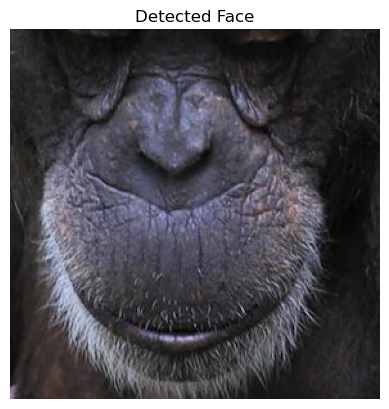

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 276 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 300 out of 300 | elapsed:    0.0s finished


Prediction HOG for 2010-06-14-Affen-Zoo-Hannover-7047-c-PETA-D.png: Robin, Confidence: 0.54


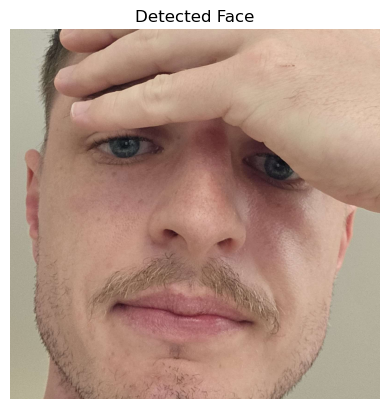

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 276 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 300 out of 300 | elapsed:    0.0s finished


Prediction HOG for 20240326_154707.jpg: Robin, Confidence: 0.5566666666666666


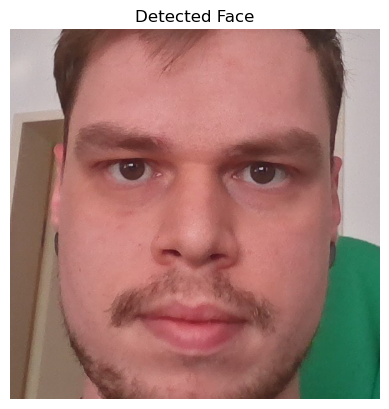

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 276 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 300 out of 300 | elapsed:    0.0s finished


Prediction HOG for image (2).jpg: Nino, Confidence: 0.57


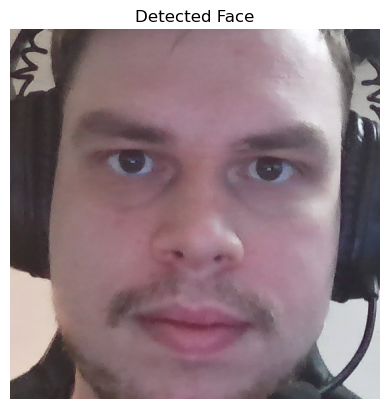

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 276 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 300 out of 300 | elapsed:    0.0s finished


Prediction HOG for image (3).jpg: Robin, Confidence: 0.51


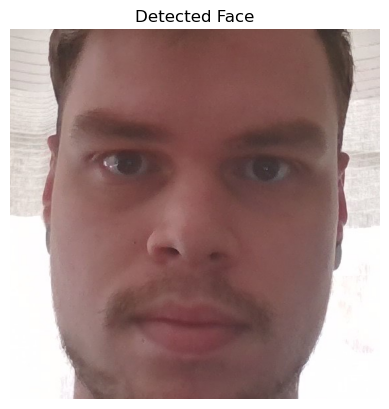

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 276 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 300 out of 300 | elapsed:    0.0s finished


Prediction HOG for image (4).jpg: Nino, Confidence: 0.5366666666666666


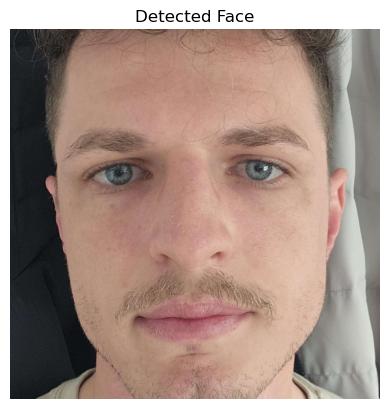

Prediction HOG for robin191.jpg: Robin, Confidence: 0.5533333333333333


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 276 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 300 out of 300 | elapsed:    0.0s finished


In [34]:
# Ordnerpfad mit den zu klassifizierenden Bildern
predict_folder = "predict"

# Iteriere über die Bilder im Ordner und führe die Vorhersage durch
for filename in os.listdir(predict_folder):
    image_path = os.path.join(predict_folder, filename)
    # Gesichtserkennung durchführen
    face = detect_face(image_path)
    if face is not None:
        # Plotte das Originalbild mit dem markierten Gesicht
        plt.imshow(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title('Detected Face')
        plt.show()

    # Vorhersage mit HOG durchführen
        prediction, confidence = predict_image_HOG(face, rf_classifier_hog, hog_pca_transformer)
        if prediction is not None:
            print(f"Prediction HOG for {filename}: {prediction}, Confidence: {confidence}")

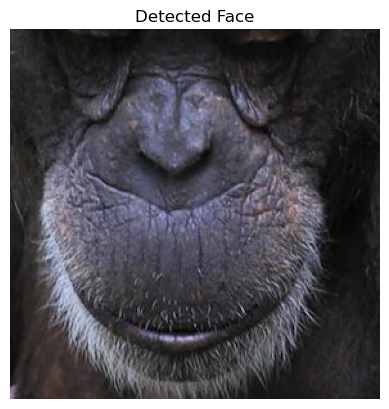

NameError: name 'rf_classifier_lbp' is not defined

In [20]:
# Ordnerpfad mit den zu klassifizierenden Bildern
predict_folder = "predict"

# Iteriere über die Bilder im Ordner und führe die Vorhersage durch
for filename in os.listdir(predict_folder):
    image_path = os.path.join(predict_folder, filename)
    # Gesichtserkennung durchführen
    face = detect_face(image_path)
    if face is not None:
        # Plotte das Originalbild mit dem markierten Gesicht
        plt.imshow(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title('Detected Face')
        plt.show()
        
        # Vorhersage mit LBP durchführen
        if rf_classifier_lbp is not None:
            prediction, confidence = predict_image_LBP(face, rf_classifier_lbp)
            if prediction is not None:
                print(f"Prediction LBP for {filename}: {prediction}, Confidence: {confidence}")
        
        # Vorhersage mit HOG durchführen
        if rf_classifier_hog is not None:
            prediction, confidence = predict_image_HOG(face, rf_classifier_hog, hog_pca_transformer)
            if prediction is not None:
                print(f"Prediction HOG for {filename}: {prediction}, Confidence: {confidence}")
        
        # Vorhersage mit Fisherface durchführen
        if lda_classifier is not None:
            prediction, confidence = predict_image_Fisherface(face, lda_classifier)
            if prediction is not None:
                print(f"Prediction Fisherface for {filename}: {prediction}, Confidence: {confidence}")
    else:
        print(f"Failed to detect face in {filename}")

## Features Visualisieren HOG

In [ ]:
# Berechnung des Durchschnitts der HOG-Merkmale für jede Klasse
average_hog_features_by_class, hog_class_labels, hog_class_counts = calculate_average_features_by_class(hog_features, hog_labels)

# Visualisierung der durchschnittlichen HOG-Merkmale für jede Klasse
plt.figure(figsize=(12, 6))
for i, label in enumerate(hog_class_labels):
    plt.plot(average_hog_features_by_class[i], label=f'Class {label} (n={hog_class_counts[label]})')

plt.xlabel('HOG Feature Index')
plt.ylabel('Average Value')
plt.title('Average HOG Features by Class')
plt.legend()
plt.show()




## Features Visualisieren LBP

In [ ]:
# Berechnung des Durchschnitts der LBP-Merkmale für jede Klasse
average_lbp_features_by_class, lbp_class_labels, lbp_class_counts = calculate_average_features_by_class(lbp_features, lbp_labels)

# Visualisierung der durchschnittlichen LBP-Merkmale für jede Klasse
plt.figure(figsize=(12, 6))
for i, label in enumerate(lbp_class_labels):
    plt.plot(average_lbp_features_by_class[i], label=f'Class {label} (n={lbp_class_counts[label]})')

plt.xlabel('LBP Feature Index')
plt.ylabel('Average Value')
plt.title('Average LBP Features by Class')
plt.legend()
plt.show()

## Features Visualisieren LDA

In [ ]:
# Berechnung des Durchschnitts der LDA-Merkmale für jede Klasse
average_lda_features_by_class, lda_class_labels, lda_class_counts = calculate_average_features_by_class(fisherface_features, fisherface_labels)

# Visualisierung der durchschnittlichen LDA-Merkmale für jede Klasse
plt.figure(figsize=(12, 6))
for i, label in enumerate(lda_class_labels):
    plt.plot(average_lda_features_by_class[i], label=f'Class {label} (n={lda_class_counts[label]})')

plt.xlabel('LDA Feature Index')
plt.ylabel('Average Value')
plt.title('Average LDA Features by Class')
plt.legend()
plt.show()